# Installation

Install all the dependencies to make the most out of docTR. The project provides two main [installation](https://mindee.github.io/doctr/latest/installing.html) streams: one for stable release (update once every 45 days on average), and developer mode.

In [19]:
import warnings

# Ignore the warning
warnings.filterwarnings("ignore")

## Latest stable release

This will install the last stable release of docTR.

In [20]:
# TensorFlow
# !pip install python-doctr[tf]
# PyTorch
!pip -q install python-doctr[torch]

In [21]:
%matplotlib inline
import os

# Let's pick the desired backend
os.environ['USE_TORCH'] = '1'

import matplotlib.pyplot as plt

from doctr.io import DocumentFile
from doctr.models import ocr_predictor

In [92]:
# Read the file
doc = DocumentFile.from_images("/home/said/courses/Projetinfo/sports_scr/data/natation/ROI/CLIP_text_prompt/000005.png")

In [93]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


from preprocess import correct_orientation

corrected_image = correct_orientation(doc[0])

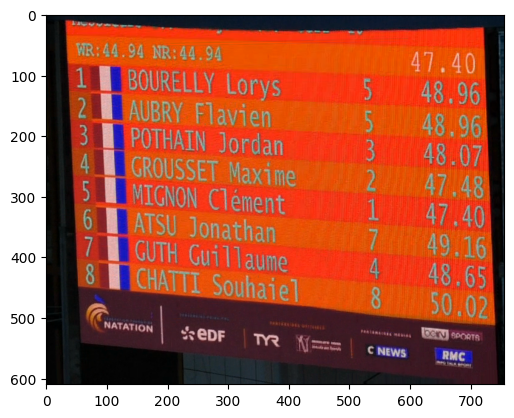

In [94]:
plt.imshow(corrected_image)

In [95]:
# Instantiate a pretrained model
predictor = ocr_predictor(pretrained=True, export_as_straight_boxes=True)

## Basic inference

In [96]:
result = predictor([corrected_image])

## Prediction visualization

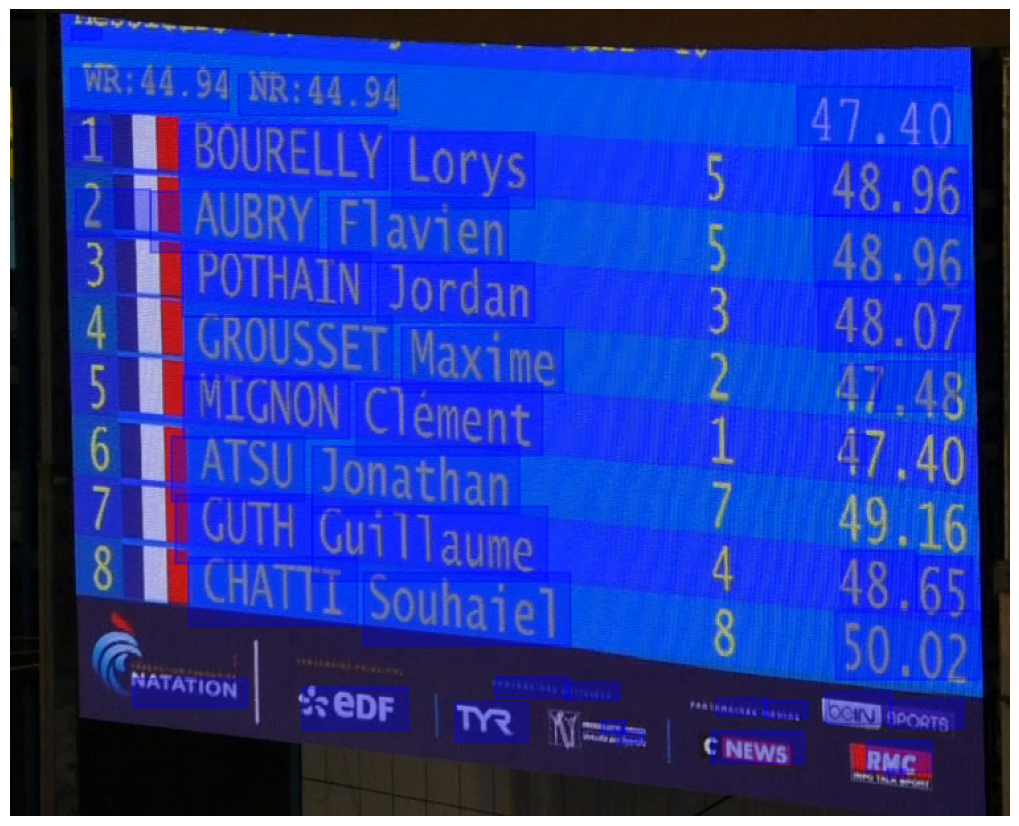

In [97]:
result.show(doc)

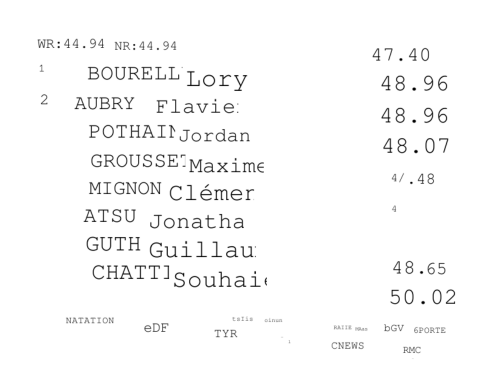

In [98]:
synthetic_pages = result.synthesize()
plt.imshow(synthetic_pages[0]); plt.axis('off'); plt.show()

## Exporting results

In [99]:
# JSON export
json_export = result.export()['pages'][0]["blocks"]

In [100]:
def reformat_doctr(raw_predictions):
    predictions = ''
    for block in raw_predictions:
        for line in block['lines']:
            for word in line['words']:
                predictions += f"{word['value']} "
            predictions += '\n'
        #predictions += ''
    return predictions.split('\n')

In [101]:
predictions = reformat_doctr(json_export)

In [102]:
def get_champions_names(sport="natation"):
    dic_names = {}
    with open("../data/champions/natation.txt", "r") as file:
        for line in file.readlines():
            split_name = line.strip().split()
            last_name, first_name = ' '.join(split_name[:-1]), split_name[-1]
            dic_names[last_name] = first_name
    return dic_names

In [103]:
dic_names = get_champions_names(sport="natation")

In [104]:
import re
import editdistance

def separate_cursed_names(string):

    # Define the regular expression pattern
    pattern = r"([A-Z]+)([A-Z]{1}[a-z]+)"

    # Remove non-alphanumeric charcaters
    string = re.sub(r'[^\w\s\-.,:]', '', string)

    # Find all words that match the pattern
    matches = re.findall(pattern, string)
    
    # Replace each match with the desired format
    for match in matches:
        old_word = ''.join(match)
        new_word = ' '.join(match)
        string = string.replace(old_word, new_word)
    return string

def extract_names_scores(input_string, min_edit_distance=3):
    # Separate cursed names
    input_string = separate_cursed_names(input_string)
    # Define the regular expression pattern
    name_pattern = r"[A-Z]+ [A-Z]{1}[a-z]{1}[\-aA-zZ]*"
    time_pattern = r"(?:\d+:)?\d+[.,]\d{2}"

    # Use the re.findall() function to find all matches in the input string
    name_matches = re.findall(name_pattern, input_string, re.MULTILINE)

    # Extract the names from the matches
    last_first_name_map = {}
    for match in name_matches:
        # Split the match into its constituent parts
        parts = match.split()
        # Extract the name
        name = " ".join(parts[:-1])

        last_first_name_map[name] = parts[-1]

    # Use the re.findall() function to find all matches in the input string
    time_matches = re.findall(time_pattern, input_string, re.MULTILINE)
    
    # Extract the names from the matches
    times = []
    for match in time_matches:
        # Split the match into its constituent parts
        parts = match.split()
        # Extract the name
        time = parts[0]
        times.append(time)
    
    # Filter names
    good_names = []
    for name in last_first_name_map.keys():
        for dic_name in dic_names.keys():
            if editdistance.eval(name, dic_name) <= min_edit_distance:
                good_names.append(name)
                break
            else:
                pass

    try :
        times = times[::-1]
        good_times = times[:len(good_names)]
        good_times = good_times[::-1]

    except Exception as e:
        print(e)
        good_times = times[0:len(good_names)]
    
    good_first_names = [v for k, v in last_first_name_map.items() if k in good_names]
    # final result : Last Name, First Name, Time
    result = [f"{last} {first} {time}" for last, first, time in zip(good_names, good_first_names, good_times)]
    return result

In [107]:
input_string = " ".join(predictions)

result = extract_names_scores(input_string, min_edit_distance=5)
result

NameError: name 'extract_names_scores' is not defined

In [108]:
predictions

[' ',
 'WR:44.94 NR:44.94 ',
 '1 ',
 '47.40 ',
 'BOURELLY Lorys ',
 '48.96 ',
 '2 AUBRY Flavien ',
 '48.96 ',
 'POTHAIN Jordan ',
 '48.07 ',
 'GROUSSET Maxime ',
 'MIGNON ',
 '4/ .48 ',
 'Clément ',
 'ATSU Jonathan ',
 '4 ',
 'GUTH Guillaume ',
 'CHATTI Souhaiel ',
 '48. 65 ',
 '50.02 ',
 'NATATION ',
 'eDF ',
 'TYR tsIis oinun - ',
 'RAIIE MAas bGV 6PORTE ',
 'l ',
 'CNEWS ',
 'RMC - ',
 '']